In [84]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from scipy.io import loadmat
from scipy.stats import pearsonr
from tqdm import tqdm
from copy import deepcopy
import pickle
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root, 'code'))
from model_fitting import initialize_fitting
from utils import roi_utils, nsd_utils


In [36]:
device = torch.device('cpu:0')

In [85]:
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 1
device#: 0
device name: GeForce RTX 2080 Ti

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32


In [3]:
sns.axes_style()
sns.set_style("white")
sns.set_context("notebook", rc={'axes.labelsize': 12.0, 'axes.titlesize': 14.0, 'legend.fontsize': 12.0, 'xtick.labelsize': 12.0, 'ytick.labelsize': 12.0})
sns.set_palette("deep")
plt.rcParams['image.cmap'] = 'viridis'

In [89]:
# Load results of the fitting procedure

subject = 1

model_params = []
model_val_cc = []
model_strs = []

paths2load = ['bdcn_fused/Sep-02-2021_1325_19/', 'bdcn_fused/Sep-02-2021_0215_28', 'bdcn_pca_fused/Sep-02-2021_0234_17', \
              'bdcn_pca_fused/Sep-02-2021_0424_53', 'bdcn_pca_fused/Aug-30-2021_2008_22', 'bdcn_pca_fused/Sep-02-2021_0507_59', \
              'bdcn_pca_fused/Aug-30-2021_0330_07/', 'bdcn_pca_fused/Aug-30-2021_0358_49/', 'bdcn_pca_fused/Aug-30-2021_0431_02/', \
              'bdcn_pca_fused/Aug-30-2021_0534_22/', 'bdcn_pca_fused/Aug-30-2021_0641_13/', 'bdcn_pca_fused/Aug-30-2021_0709_00/', \
              'bdcn_pca_fused/Aug-30-2021_1903_24/', 'bdcn_pca_fused/Aug-30-2021_2008_22' ]

for path in paths2load:
    
    out = torch.load(os.path.join('/user_data/mmhender/imStat/model_fits/S01/', path,'all_fit_params'))
    pars = {'n_prf_sd_out': out['n_prf_sd_out'], 'mult_patch_by_prf': out['mult_patch_by_prf'], \
                        'ridge': out['ridge'], 'do_pca': out['do_pca']}
    if 'do_nms' in out.keys():
        pars['do_nms'] = out['do_nms']
    else:
        pars['do_nms'] = False
    if 'downsample_factor' in out.keys():
        pars['downsample_factor'] = out['downsample_factor']
    else:
        pars['downsample_factor'] = 1.0
        
    s = 'pca%s_sd%d_mult%s_ridge%s_nms%s_ds%.2f'%(pars['do_pca'], pars['n_prf_sd_out'], pars['mult_patch_by_prf'], pars['ridge'], \
                                           pars['do_nms'], pars['downsample_factor'])
       
    model_strs.append(s)
    model_params.append(pars)
    model_val_cc.append(out['val_cc'])
    
    

Text(0.5, 0.98, 'S01, hV4, bdcn_pca_fused\nComparing model performance to noise ceiling')

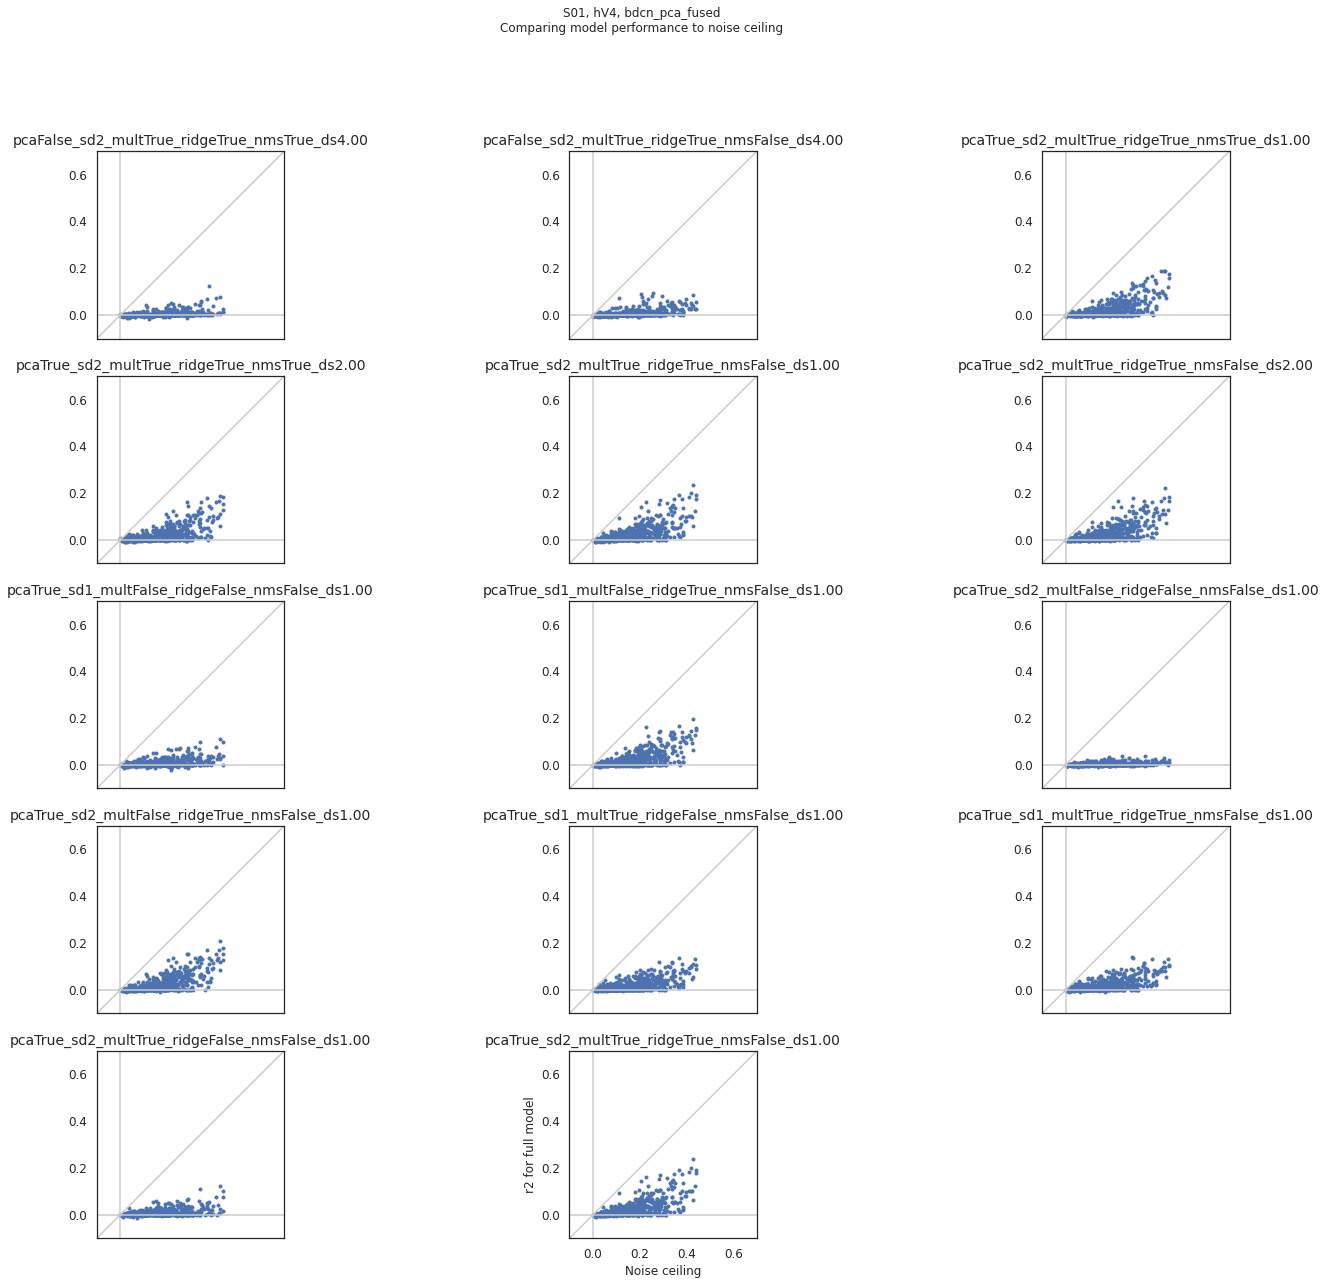

In [92]:
# Scatter plot comparing model prediction to noise ceiling

n_models = len(model_params)
plt.figure(figsize=(24,20))
npy = 3
npx= int(np.ceil(n_models/npy))
# npx = int(np.ceil(np.sqrt(n_models)))
# npy = 


xlims = [-0.1, 0.7]
ylims = [-0.1, 0.7]

rr = 3

if rr<n_rois_ret:
    inds_this_roi = np.isin(roi_labels_retino, ret_group_inds[rr])
    rname = ret_group_names[rr]
else:
    inds_this_roi = np.isin(roi_labels_categ, categ_group_inds[rr-n_rois_ret])
    rname = categ_group_names[rr-n_rois_ret]

inds2use = inds_this_roi
    

for mm in range(n_models):
  
    plt.subplot(npx,npy,mm+1)
   
    xvals = noise_ceiling[inds2use]/100
    cc = model_val_cc[mm][inds2use]
    yvals = np.sign(cc) * cc**2

    plt.plot(xvals,yvals,'.')
    if mm==n_models-1:
        plt.xlabel('Noise ceiling')
        plt.ylabel('r2 for full model')
    else:
        plt.xticks([])
    plt.axis('square')

    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.plot(xlims, ylims, color=[0.8, 0.8, 0.8])
    plt.axvline(color=[0.8, 0.8, 0.8])
    plt.axhline(color=[0.8, 0.8, 0.8])
        
    plt.title(model_strs[mm])

plt.suptitle('S%02d, %s, %s\nComparing model performance to noise ceiling'%(subject, rname, fitting_type))

# plt.savefig(os.path.join(fig_save_folder,'r2_vs_noiseceiling.png'))
# plt.savefig(os.path.join(fig_save_folder,'r2_vs_noiseceiling.pdf'))

Text(0.5, 0.98, 'S01\nComparing model performance w different hyperpars')

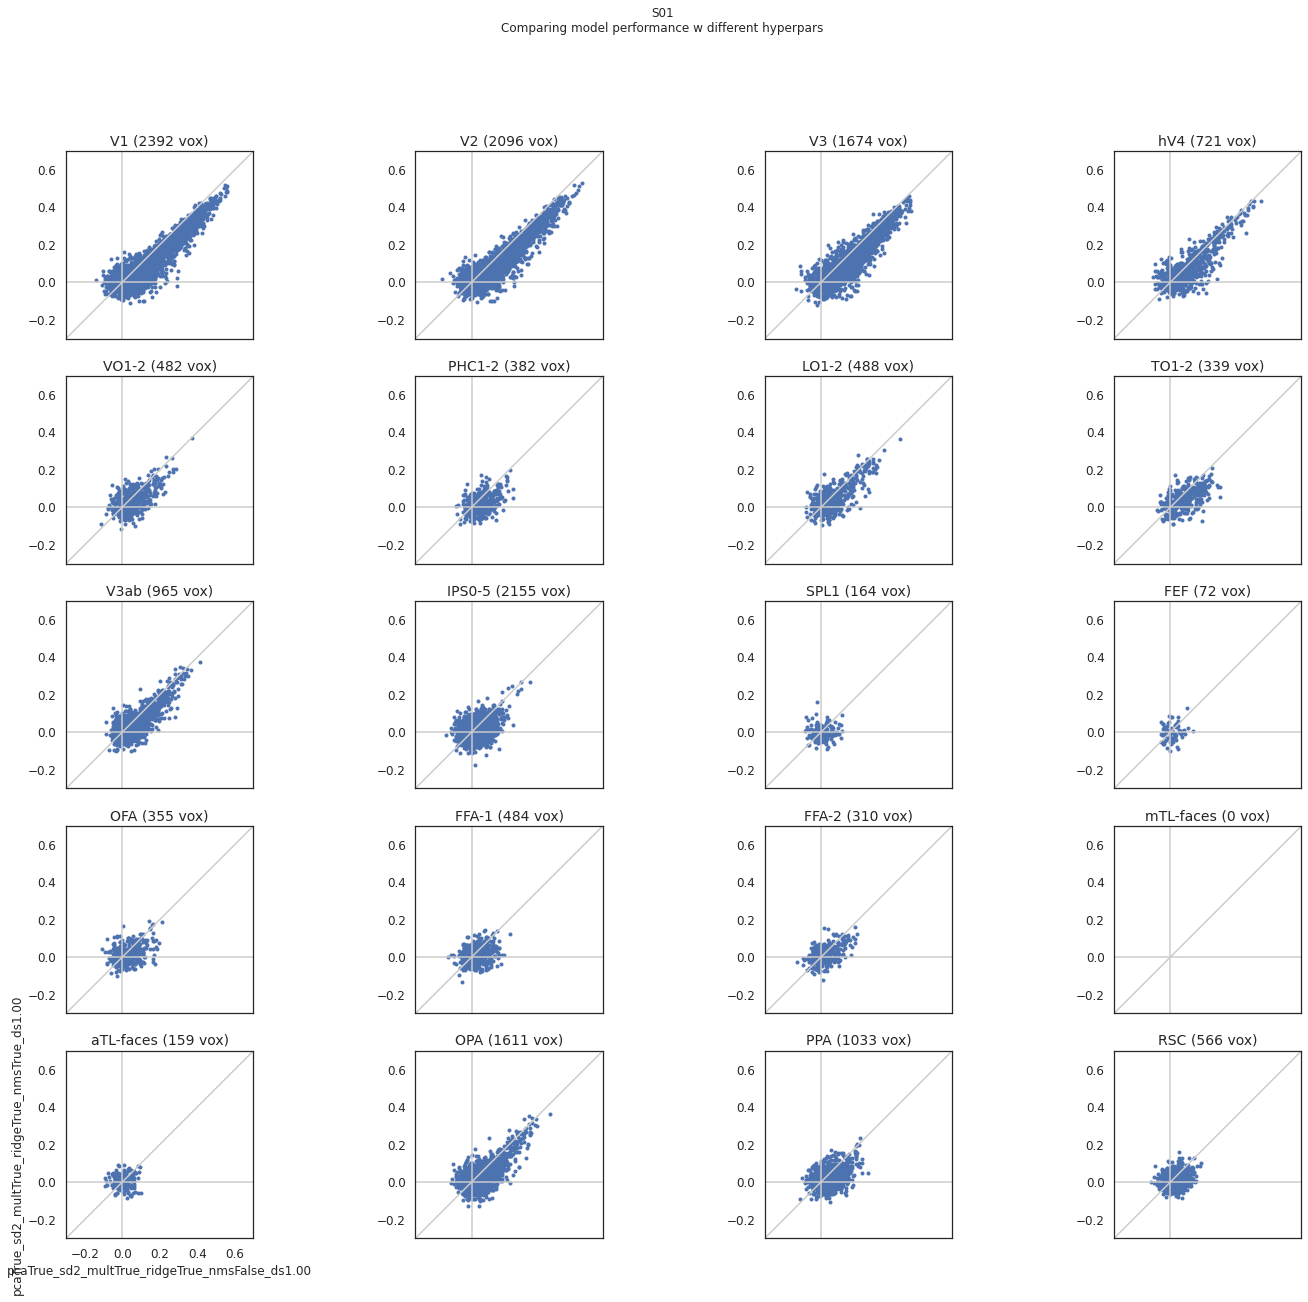

In [95]:
# Scatter plot comparing model prediction to noise ceiling

# mm1 = 4
# mm2 = 5

mm1 = 4
mm2 = 2

plt.figure(figsize=(24,20))
npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

xlims = [-0.3, 0.7]
ylims = [-0.3, 0.7]

for rr in range(n_rois):
       
    if rr<n_rois_ret:
        inds_this_roi = np.isin(roi_labels_retino, ret_group_inds[rr])
        rname = ret_group_names[rr]
    else:
        inds_this_roi = np.isin(roi_labels_categ, categ_group_inds[rr-n_rois_ret])
        rname = categ_group_names[rr-n_rois_ret]
  
    inds2use = inds_this_roi
    
    plt.subplot(npx,npy,rr+1)
   
    if np.sum(inds2use)>0:
        
        xvals = model_val_cc[mm1][inds2use]
        yvals = model_val_cc[mm2][inds2use]

        plt.plot(xvals,yvals,'.')

    if rr==n_rois-4:
        plt.xlabel(model_strs[mm1])
        plt.ylabel(model_strs[mm2])
    else:
        plt.xticks([])
    plt.axis('square')

    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.plot(xlims, ylims, color=[0.8, 0.8, 0.8])
    plt.axvline(color=[0.8, 0.8, 0.8])
    plt.axhline(color=[0.8, 0.8, 0.8])
    
    
    plt.title('%s (%d vox)'%(rname, np.sum(inds2use)))

plt.suptitle('S%02d\nComparing model performance w different hyperpars'%(subject))

# plt.savefig(os.path.join(fig_save_folder,'r2_vs_noiseceiling.png'))
# plt.savefig(os.path.join(fig_save_folder,'r2_vs_noiseceiling.pdf'))